In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
     

# **Problem 1**

In [3]:
class GMM:
  REG_COV = 1e-6
  def __init__(self):
    """Initialize number of clusters and max iteration time for the model"""
    self._k = None   # number of clusters/components 
    self._iter = None # number of iterations to fit model
    self._pi = None       # vector containing pi value for each cluster
    self._mu = None       # matrix containing mean vector for k clusters
    self._cov = None      # covar matrices for k clusters
    self._r = None        # responsibility matrix
    self.log_likelihoods = []
    self._data = None

  def e_step(self):
    """e-step calculation, this method must be called inside fit method"""
    n_data_point = self._data.shape[0]
    self._r = np.zeros((n_data_point, self._k))

    for pi, mu, cov, col in zip(self._pi, self._mu, self._cov, range(self._k)):
      # initialize Normal distribution with corresponding mean and cov
      cov += self.REG_COV * np.identity(self._data.shape[1])
      mn = multivariate_normal(mean=mu, cov=cov)
      # calculate each col in responsibility matrix, i.e the probability of cluster k for each dpoint
      self._r[:, col] = pi * mn.pdf(self._data)

    for row in range(n_data_point):
      # calculate each row in responsibility matrix, i.e the probability of a dpoint for each cluster
      self._r[row, :] = self._r[row, :] / np.sum(self._r[row, :])

  def m_step(self):
    """m-step calculation, this method must be called inside fit method"""
    r_k = np.sum(self._r, axis=0) # vector for total responsibility of each cluster
    self._pi = r_k / np.sum(r_k)
    self._mu = np.dot(self._r.T, self._data) / r_k.reshape(self._k, 1)

    self._cov = []
    for i in range(self._k):
      r_i = r_k[i] # total responsibility of cluster i
      r_vector_i = self._r[:, i].reshape(-1, 1)
      x_diff_mu = self._data - self._mu[i]
      cov_i = 1 / r_i * (np.dot((r_vector_i * x_diff_mu).T, x_diff_mu))
      self._cov.append(cov_i + self.REG_COV * np.identity(self._data.shape[1]))
    self._cov = np.asarray(self._cov)

  def get_loglikelihood(self):
    likelihood = []
    for i in range(self._k):
      reg = self.REG_COV * np.identity(self._data.shape[1])
      pdf = multivariate_normal(self._mu[i], self._cov[i] + reg).pdf(self._data)
      likelihood.append(self._pi[i] * pdf)
    return np.log(np.sum(likelihood))

  def fit(self, data, n_clusters, max_iter):
    """Model implementation and fit 2D data"""
    self._data = np.array(data)
    self._k = n_clusters
    self._iter = max_iter
    self.log_likelihoods = []
    data_dim = self._data.shape[1]

    # Model param initialization
    self._pi = np.ones(self._k) / self._k
    temp = np.array_split(self._data, self._k)
    self._mu = np.asarray([np.mean(x, axis=0) for x in temp])
    self._cov = np.asarray([np.cov(x.T) for x in temp])
    del temp

    for iter in range(self._iter):
      self.e_step()
      self.m_step()
      self.log_likelihoods.append(np.sum(self.get_loglikelihood()))
    cluster = np.argmax(self._r, axis=1)
    return self._pi, self._mu, self._cov, cluster

  def get_distortion(self):
    """distortion is the overall distance from each point to its cluster mean"""
    distortion = 0
    for i in range(self._data.shape[0]):
      k = np.argmax(self._r[i])
      distortion += np.linalg.norm(self._data[i] - self._mu[k])
    return distortion

  def predict(self, x):
    """Predicting cluster for new samples in array x"""
    x = np.array(x)
    predictions = []
    for pi, mu, cov in zip(self._pi, self._mu, self._cov):
      prob = pi * multivariate_normal(mean=mu, cov=cov).pdf(x)
      predictions.append([prob])
    predictions = np.asarray(predictions).reshape(len(x), self._k)
    predictions = np.argmax(predictions, axis=1)
    return predictions

  def visualize(self, true_label):
    """Visualize clustering result after fitting model to data"""
    x, y = np.meshgrid(np.sort(self._data[:,0]), np.sort(self._data[:,1]))
    XY = np.array([x.flatten(), y.flatten()]).T
    n = self._data.shape[0]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    for i in range(len(true_label)):
      ax.scatter(self._data[true_label == i, 0], self._data[true_label == i, 1], alpha=0.5)
    ax.set_title(f"GMM Clustering Result with number of clusters {self._k}")

    for mu, cov in zip(self._mu, self._cov):
      cov += self.REG_COV * np.identity(self._data.shape[1])
      multi_normal = multivariate_normal(mean=mu, cov=cov).pdf(XY)
      ax.contour(np.sort(self._data[:, 0]), np.sort(self._data[:, 1]), multi_normal.reshape(n, n), colors = 'black', alpha = 0.3)
      ax.scatter(mu[0], mu[1], c='red', zorder=10, s=100)
    plt.show()

# **Problem 2**

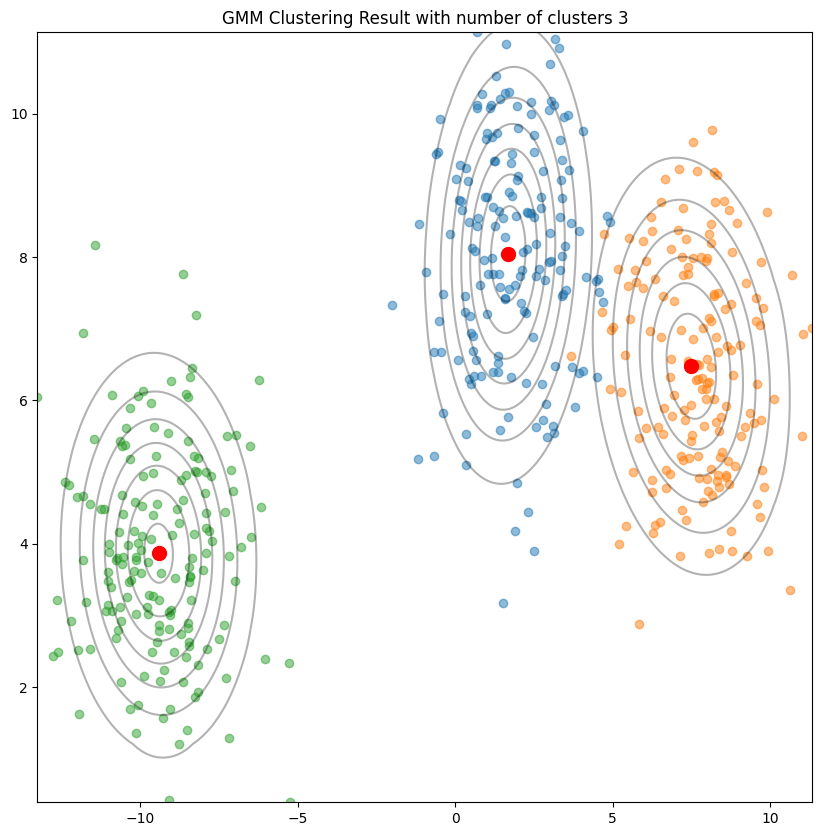

In [4]:
n_cluster = 3
X1,Y1 = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=n_cluster)
gmm2d = GMM()
gmm2d.fit(X1, n_clusters=n_cluster, max_iter=50)
gmm2d.visualize(true_label=Y1)

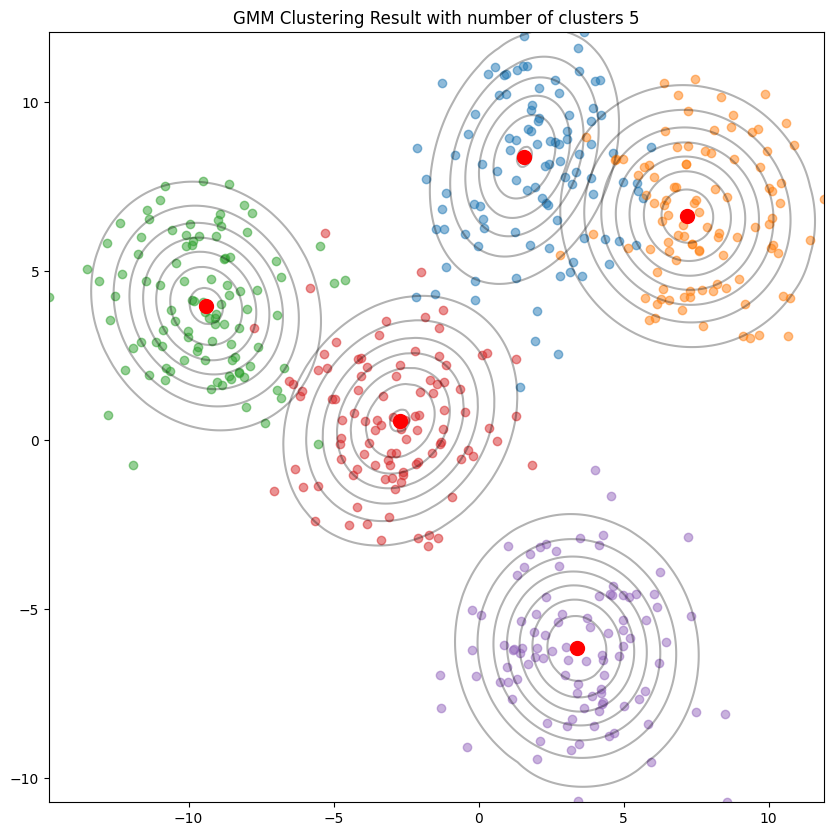

In [5]:
n_cluster = 5
X2,Y2 = make_blobs(cluster_std=2,random_state=20, n_samples=500,centers=n_cluster)
gmm2d = GMM()
gmm2d.fit(X2, n_clusters=n_cluster, max_iter=100)
gmm2d.visualize(true_label=Y2)

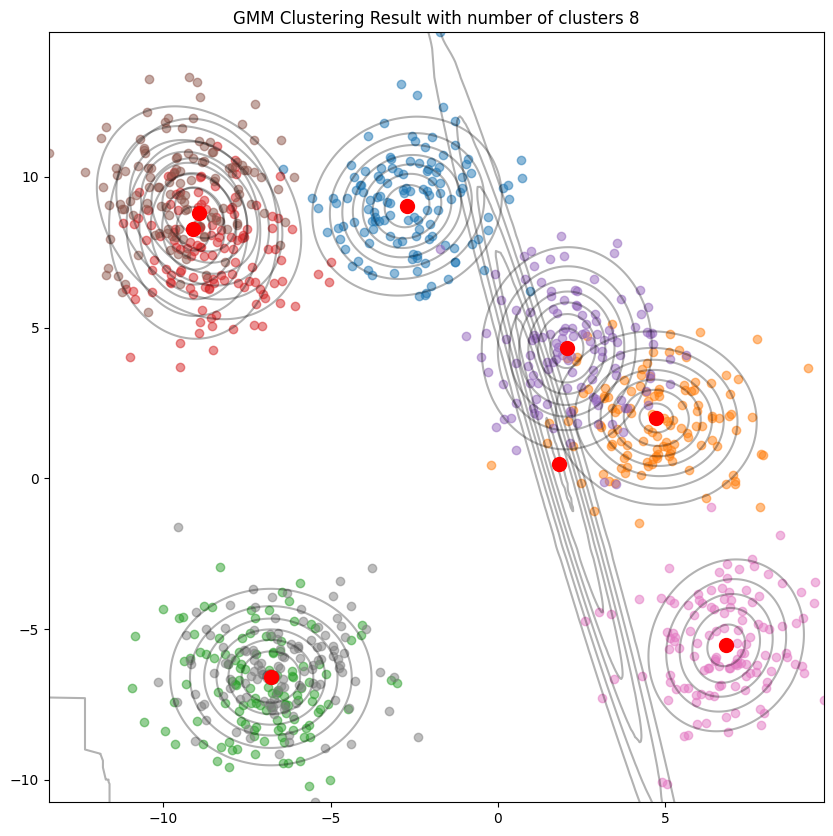

In [6]:
n_cluster = 8
X3, Y3 = make_blobs(cluster_std=1.5, random_state=42, n_samples=1000,centers=n_cluster)
gmm2d = GMM()
gmm2d.fit(X3, n_clusters=n_cluster, max_iter=200)
gmm2d.visualize(true_label=Y3)

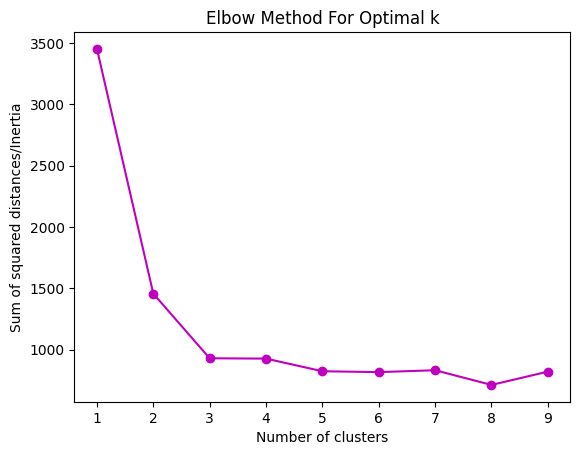

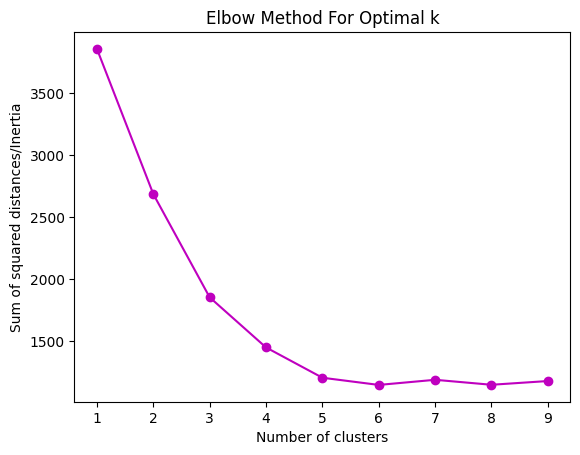

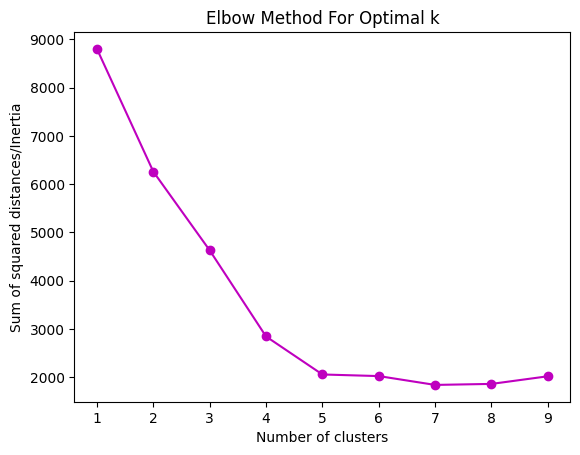

In [7]:
def elbow_curve_visualize(x, max_cluster):
  distances = []
  clusters = range(1, max_cluster)
  for n_cluster in clusters:
    gmm = GMM()
    pi, mu, cov, cluster = gmm.fit(x, n_clusters=n_cluster, max_iter=200)
    d = gmm.get_distortion()
    distances.append(d)
  plt.plot(clusters, distances, 'mo-')
  plt.xlabel('Number of clusters') 
  plt.ylabel('Sum of squared distances/Inertia') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

elbow_curve_visualize(X1, 10)
elbow_curve_visualize(X2, 10)
elbow_curve_visualize(X3, 10)

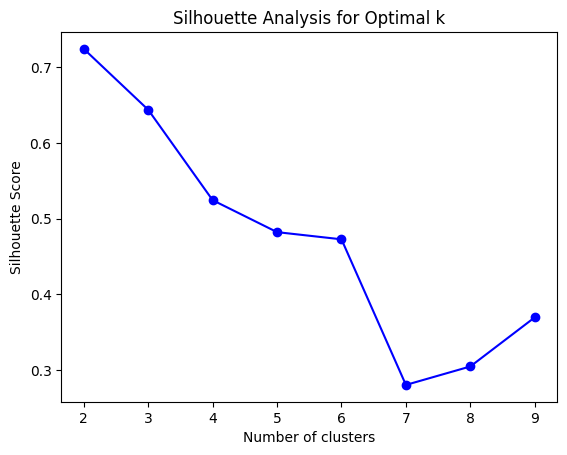

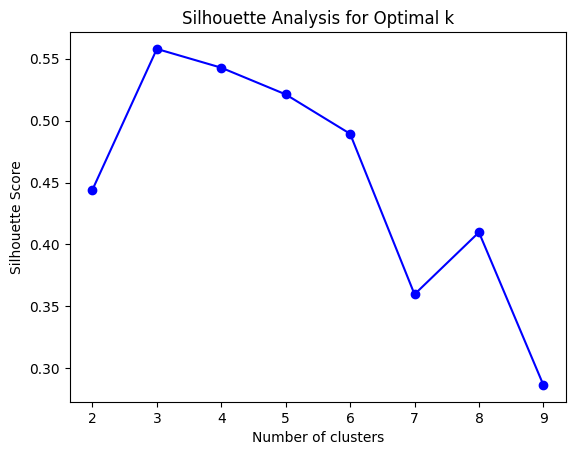

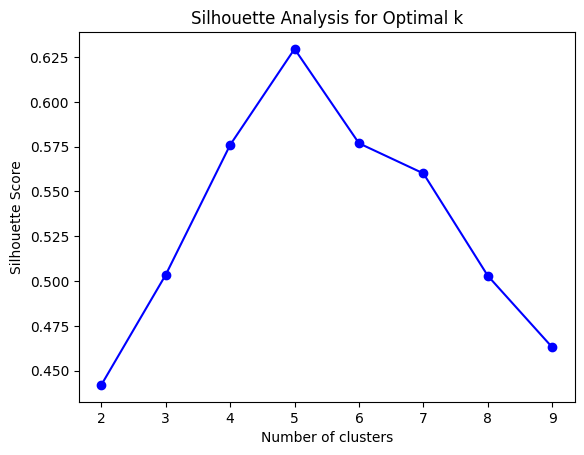

In [8]:
from sklearn.metrics import silhouette_score

def silhouette_score_visualize(x, max_cluster):
  score = []
  clusters = range(2, max_cluster)
  for k in clusters:
    gmm = GMM()
    pi, mu, cov, cluster = gmm.fit(x, n_clusters=k, max_iter=200)
    s_k = silhouette_score(x, cluster, metric='euclidean')
    score.append(s_k)
  plt.plot(clusters, score, 'bo-')
  plt.xlabel('Number of clusters') 
  plt.ylabel('Silhouette Score') 
  plt.title('Silhouette Analysis for Optimal k')
  plt.show()  

silhouette_score_visualize(X1, 10)
silhouette_score_visualize(X2, 10)
silhouette_score_visualize(X3, 10)

# **Problem 3**

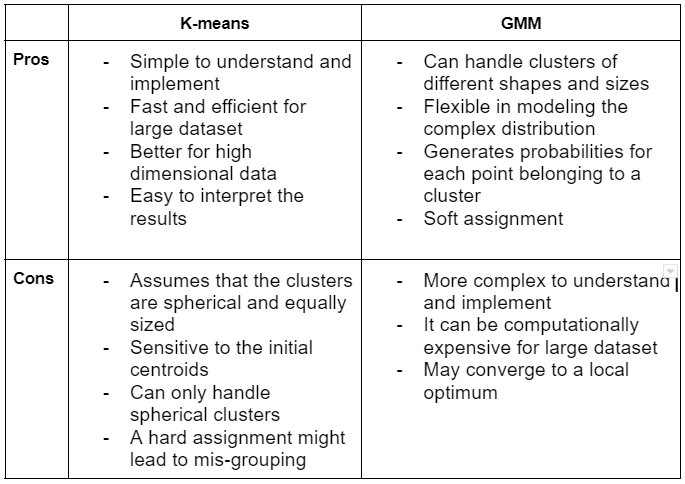